In [1]:
from __future__ import print_function

import math

from IPython import display
from matplotlib import cm
from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn import metrics
import tensorflow as tf
from tensorflow.python.data import Dataset

tf.logging.set_verbosity(tf.logging.ERROR)
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.1f}'.format

In [2]:
global_styling_dataframe = pd.read_json("performance_test_result/00_progress-bar/00-global-styling/BodyRendering.json")
js_component_dataframe = pd.read_json("performance_test_result/00_progress-bar/01-js-component/BodyRendering.json")
web_component_dataframe = pd.read_json("performance_test_result/00_progress-bar/02-webcomponent/BodyRendering.json")
angular_dataframe = pd.read_json("performance_test_result/00_progress-bar/03-angular/BodyRendering.json")
polymer_dataframe = pd.read_json("performance_test_result/00_progress-bar/04-polymer/BodyRendering.json")
vue_dataframe = pd.read_json("performance_test_result/00_progress-bar/05-vue/BodyRendering.json")
angular_plain_dataframe = pd.read_json("performance_test_result/00_progress-bar/03-angular/plain/BodyRendering.json")
polymer_plain_dataframe = pd.read_json("performance_test_result/00_progress-bar/04-polymer/plain/BodyRendering.json")
vue_plain_dataframe = pd.read_json("performance_test_result/00_progress-bar/05-vue/plain/BodyRendering.json")

frames = [global_styling_dataframe, 
          js_component_dataframe,
          web_component_dataframe]
performance_columns = ['global_styling', 'js_component', 'web_component']

frames_frameworks = [angular_dataframe,
                     polymer_dataframe,
                     vue_dataframe]
performance_columns_frameworks = ['angular', 'polymer', 'vue']

frames_frameworks_plain = [angular_plain_dataframe,
                           polymer_plain_dataframe,
                           vue_plain_dataframe]
performance_columns_frameworks_plain = ['angular_plain', 'polymer_plain', 'vue_plain']

performance_dataframe = pd.concat(frames, axis=1, sort=False)
performance_dataframe.columns = performance_columns
performance_dataframe = performance_dataframe.tail(-1)

performance_dataframe_frameworks_only = pd.concat(frames_frameworks + frames_frameworks_plain, axis=1, sort=False)
performance_dataframe_frameworks_only.columns = performance_columns_frameworks + performance_columns_frameworks_plain
performance_dataframe_frameworks_only = performance_dataframe_frameworks_only.tail(-1)

performance_dataframe_frameworks = pd.concat(frames + frames_frameworks, axis=1, sort=False)
performance_dataframe_frameworks.columns = performance_columns + performance_columns_frameworks
performance_dataframe_frameworks = performance_dataframe_frameworks.tail(-1)

performance_dataframe_plain = pd.concat(frames + frames_frameworks_plain, axis=1, sort=False)
performance_dataframe_plain.columns = performance_columns + performance_columns_frameworks_plain
performance_dataframe_plain = performance_dataframe_plain.tail(-1)

performance_dataframe


,global_styling,js_component,web_component
1,105.9,120.7,119.6
2,109.2,115.1,120.7
3,104.5,118.2,123.0
4,107.1,116.2,122.8
5,108.1,113.0,117.6
...,...,...,...
95,111.0,116.6,124.4
96,105.6,120.2,129.0
97,107.7,116.8,121.8
98,106.6,117.5,127.6


<Figure size 432x288 with 0 Axes>

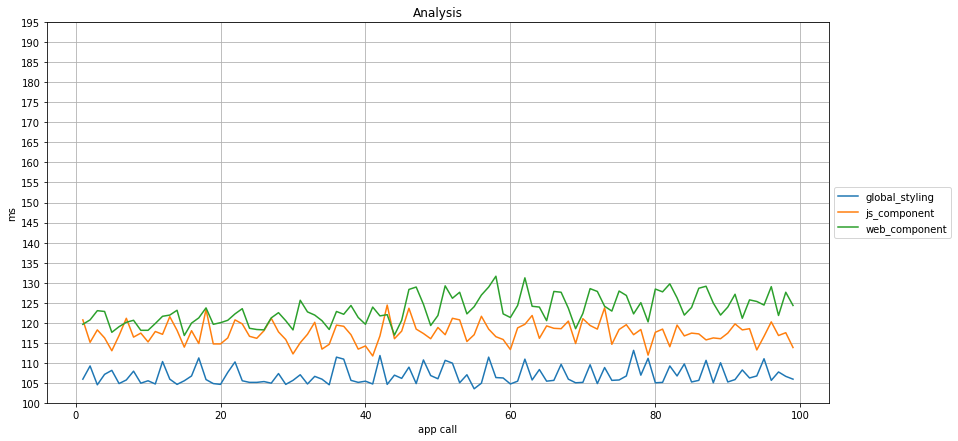

<Figure size 432x288 with 0 Axes>

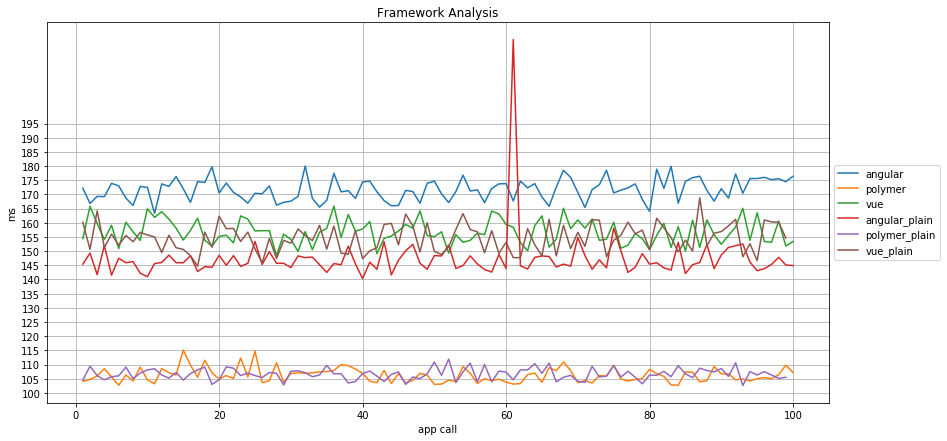

<Figure size 432x288 with 0 Axes>

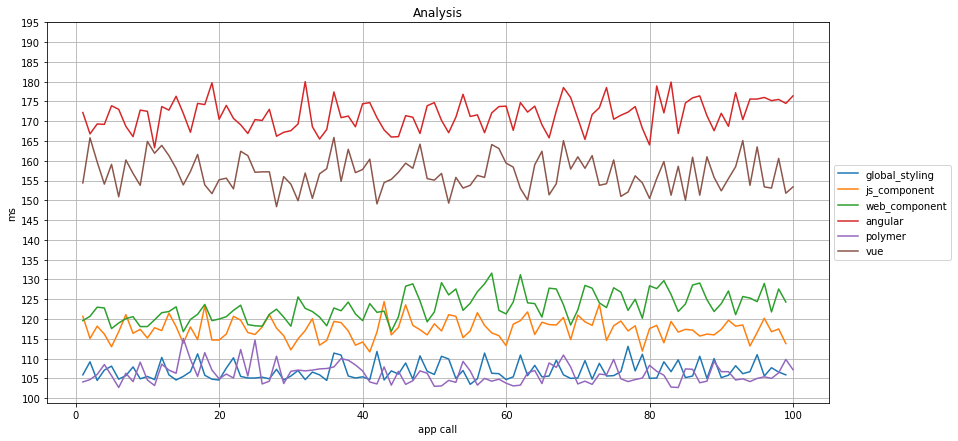

<Figure size 432x288 with 0 Axes>

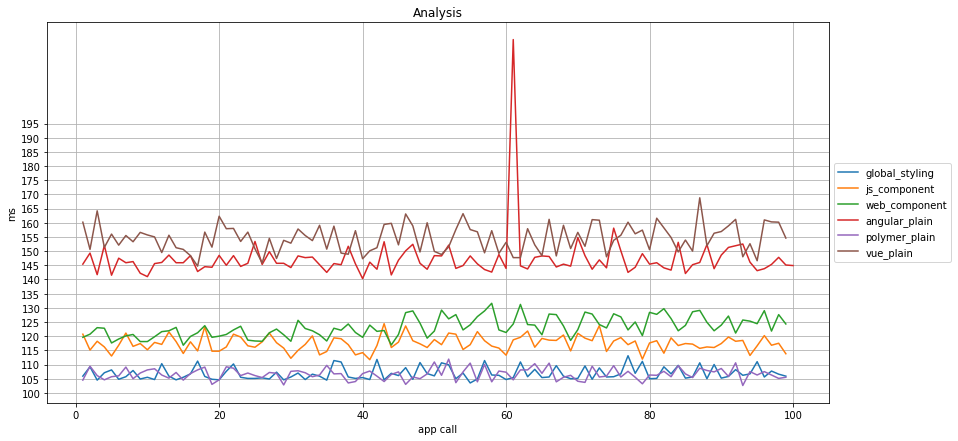

In [4]:
f = plt.figure()
performance_dataframe.plot(kind='line',figsize=(14,7), title="Analysis", grid=True, yticks=range(100,200,5),stacked = False)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.ylabel("ms")
plt.xlabel("app call")
plt.show()

f = plt.figure()
performance_dataframe_frameworks_only.plot(kind='line',figsize=(14,7), title="Framework Analysis",yticks=range(100,200,5), grid=True,stacked = False)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.ylabel("ms")
plt.xlabel("app call")
plt.show()

f = plt.figure()
performance_dataframe_frameworks.plot(kind='line',figsize=(14,7), title="Analysis", grid=True, yticks=range(100,200,5), stacked = False)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.ylabel("ms")
plt.xlabel("app call")
plt.show()

f = plt.figure()
performance_dataframe_plain.plot(kind='line',figsize=(14,7), title="Analysis", grid=True, yticks=range(100,200,5), stacked = False)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.ylabel("ms")
plt.xlabel("app call")
plt.show()

